In [1]:
#IMPORTING LIBRARIES
import uproot
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from numpy import mean
from numpy import std
import zfit

from xgboost import XGBClassifier, callback, plot_importance
from sklearn.model_selection import train_test_split, KFold, cross_val_score, StratifiedKFold
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, roc_curve, auc
from sklearn.preprocessing import StandardScaler
import pickle
import optuna
import joblib
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder
import random 

/afs/cern.ch/user/k/ktrofimi/.venv/lib64/python3.9/site-packages/zfit/__init__.py:60: UserWarning: TensorFlow warnings are by default suppressed by zfit. In order to show them, set the environment variable ZFIT_DISABLE_TF_WARNINGS=0. In order to suppress the TensorFlow warnings AND this warning, set ZFIT_DISABLE_TF_WARNINGS=1.
  warnings.warn(
2025-02-25 10:30:46.133033: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1740475846.152825 3890496 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1740475846.157914 3890496 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
/afs/cern.ch/user/k/ktrofimi/.venv/lib64/python3.9/site-packages/tqdm/auto.py:21: TqdmWarni

In [2]:
#SELECTION DEFINITION

NEW_SELECTION = (
    "((Dst_M - D0_M) > 143) & ((Dst_M - D0_M) < 148) & "
    "(K_IPCHI2_OWNPV > 3) & (pi_IPCHI2_OWNPV > 3) & "
    "(K_TRACK_CHI2NDOF < 3.) & (pi_TRACK_CHI2NDOF < 3.) & "
    "(K_PT > 500.) & (pi_PT > 500.) & "
    "(K_hasRich == 1) & (pi_hasRich == 1) & "
    "(mp_TRACK_CHI2NDOF < 3.) & "
    "(mm_TRACK_CHI2NDOF < 3.) & "
    "(mp_isMuon == 1) & (mm_isMuon == 1) & "
    "(mp_PIDmu > 0) & (mm_PIDmu > 0) & "
    "(mp_PT > 250) & (mm_PT > 250) & "
    "(mp_IPCHI2_OWNPV > 3.) & (mm_IPCHI2_OWNPV > 3.) & "
    "(Jpsi_M < 3127) & (Jpsi_M > 3067) & "
    "(Bc_ENDVERTEX_CHI2 < 4.) & "
    "(Bc_IPCHI2_OWNPV < 8.) & "
    "(Bc_DIRA_OWNPV > 0.998) &"
    "(D0_ENDVERTEX_CHI2 < 8.) &"
    "(D0_M > 1835) & (D0_M < 1895) &"
    "(K_ProbNNghost < 0.3) & (pi_ProbNNghost < 0.3) & "
    "(mm_ProbNNghost < 0.3) & (mp_ProbNNghost < 0.3) & "
    "(K_ProbNNk > 0.1) & (pi_ProbNNpi > 0.1) & "
    "(Jpsi_ENDVERTEX_CHI2 < 9.) &"
    "(Dst_ENDVERTEX_CHI2 < 9.) &"
    "(abs(Dst_M - 2010.) < 30.) &"
    "(Dst_PT > 2500.) &"
    "(pi_soft_TRACK_CHI2NDOF < 3.) &"
    "(pi_soft_TRACK_GhostProb < 0.3)"
)

In [3]:
#LOADING DATASET

files_simu = [
    '/eos/user/f/facglase/tuples/Bc2JpsiDst/mc/Bc2JpsiDst_Kpi/2011_MagDown.root',
    '/eos/user/f/facglase/tuples/Bc2JpsiDst/mc/Bc2JpsiDst_Kpi/2011_MagUp.root',
    '/eos/user/f/facglase/tuples/Bc2JpsiDst/mc/Bc2JpsiDst_Kpi/2012_MagDown.root',
    '/eos/user/f/facglase/tuples/Bc2JpsiDst/mc/Bc2JpsiDst_Kpi/2012_MagUp.root',
    '/eos/user/f/facglase/tuples/Bc2JpsiDst/mc/Bc2JpsiDst_Kpi/2015_MagDown.root',
    '/eos/user/f/facglase/tuples/Bc2JpsiDst/mc/Bc2JpsiDst_Kpi/2015_MagUp.root',
    '/eos/user/f/facglase/tuples/Bc2JpsiDst/mc/Bc2JpsiDst_Kpi/2016_MagDown.root',
    '/eos/user/f/facglase/tuples/Bc2JpsiDst/mc/Bc2JpsiDst_Kpi/2016_MagUp.root',
    '/eos/user/f/facglase/tuples/Bc2JpsiDst/mc/Bc2JpsiDst_Kpi/2017_MagDown.root',
    '/eos/user/f/facglase/tuples/Bc2JpsiDst/mc/Bc2JpsiDst_Kpi/2017_MagUp.root',
    '/eos/user/f/facglase/tuples/Bc2JpsiDst/mc/Bc2JpsiDst_Kpi/2018_MagDown.root',
    '/eos/user/f/facglase/tuples/Bc2JpsiDst/mc/Bc2JpsiDst_Kpi/2018_MagUp.root',
]

files_real_data = [
    '/eos/user/f/facglase/tuples/Bc2JpsiDst/data/Kpi/2011_MagDown.root',
    '/eos/user/f/facglase/tuples/Bc2JpsiDst/data/Kpi/2011_MagUp.root',
    '/eos/user/f/facglase/tuples/Bc2JpsiDst/data/Kpi/2012_MagDown.root',
    '/eos/user/f/facglase/tuples/Bc2JpsiDst/data/Kpi/2012_MagUp.root',
    '/eos/user/f/facglase/tuples/Bc2JpsiDst/data/Kpi/2015_MagDown.root',
    '/eos/user/f/facglase/tuples/Bc2JpsiDst/data/Kpi/2015_MagUp.root',
    '/eos/user/f/facglase/tuples/Bc2JpsiDst/data/Kpi/2016_MagDown.root',
    '/eos/user/f/facglase/tuples/Bc2JpsiDst/data/Kpi/2016_MagUp.root',
    '/eos/user/f/facglase/tuples/Bc2JpsiDst/data/Kpi/2017_MagDown.root',
    '/eos/user/f/facglase/tuples/Bc2JpsiDst/data/Kpi/2017_MagUp.root',
    '/eos/user/f/facglase/tuples/Bc2JpsiDst/data/Kpi/2018_MagDown.root',
    '/eos/user/f/facglase/tuples/Bc2JpsiDst/data/Kpi/2018_MagUp.root',
]
simu_data = uproot.concatenate(files_simu, cut = f"{NEW_SELECTION} & (Bc_BKGCAT == 0)", library='pd')
real_data = uproot.concatenate(files_real_data, cut = f"{NEW_SELECTION} & ((Bc_FullDTF_M < 6250.) | (Bc_FullDTF_M > 6300.))", library='pd')
real_data['delta_mass'] = real_data['Dst_M'] - real_data['D0_M']
simu_data['delta_mass'] = simu_data['Dst_M'] - simu_data['D0_M']


/tmp/ktrofimi/ipykernel_3890496/3879935286.py:34: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  real_data['delta_mass'] = real_data['Dst_M'] - real_data['D0_M']
/tmp/ktrofimi/ipykernel_3890496/3879935286.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  simu_data['delta_mass'] = simu_data['Dst_M'] - simu_data['D0_M']


In [4]:
simu_data["min_mm_mp_PT"] = simu_data[["mm_PT", "mp_PT"]].min(axis=1)
simu_data["max_mm_mp_PT"] = simu_data[["mm_PT", "mp_PT"]].max(axis=1)

simu_data["min_K_pi_PT"] = simu_data[["K_PT", "pi_PT"]].min(axis=1)
simu_data["max_K_pi_PT"] = simu_data[["K_PT", "pi_PT"]].max(axis=1)

real_data["min_mm_mp_PT"] = real_data[["mm_PT", "mp_PT"]].min(axis=1)
real_data["max_mm_mp_PT"] = real_data[["mm_PT", "mp_PT"]].max(axis=1)

real_data["min_K_pi_PT"] = real_data[["K_PT", "pi_PT"]].min(axis=1)
real_data["max_K_pi_PT"] = real_data[["K_PT", "pi_PT"]].max(axis=1)


/tmp/ktrofimi/ipykernel_3890496/789072450.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  simu_data["min_mm_mp_PT"] = simu_data[["mm_PT", "mp_PT"]].min(axis=1)
/tmp/ktrofimi/ipykernel_3890496/789072450.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  simu_data["max_mm_mp_PT"] = simu_data[["mm_PT", "mp_PT"]].max(axis=1)
/tmp/ktrofimi/ipykernel_3890496/789072450.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider jo

In [5]:
feature_columns_previous = [
 
    'D0_M', 
    'K_IPCHI2_OWNPV',
    'pi_IPCHI2_OWNPV',
    'K_hasRich',
    'pi_hasRich',
    'K_ProbNNk',
    'mp_IPCHI2_OWNPV',
    'mm_IPCHI2_OWNPV',
    'Jpsi_M',
    'pi_soft_TRACK_GhostProb',
    'Bc_ENDVERTEX_CHI2',
    'Bc_IPCHI2_OWNPV',
    'Bc_DIRA_OWNPV',
    'min_K_pi_PT',  
]

feature_columns_original = [
 
    'min_mm_mp_PT',
    'max_mm_mp_PT',
    'Bc_ENDVERTEX_CHI2',
    'Bc_IPCHI2_OWNPV',

    'Bc_FD_OWNPV',
    'Jpsi_FD_ORIVX',
    'D0_FD_ORIVX',

    'min_K_pi_PT'
]


In [6]:

X_simu = simu_data[feature_columns_original]
y_simu = np.ones(len(simu_data))  # Label: 1 for simulation data

X_real = real_data[feature_columns_original]
y_real = np.zeros(len(real_data))  # Label: 0 for real data

# Combine features and labels
X_all = pd.concat([X_simu, X_real], ignore_index=True)
y_all = np.concatenate([y_simu, y_real])

print(f"SIMULATION set size: {X_simu.shape}")
print(f"REAL DATA set size: {X_real.shape}")

SIMULATION set size: (38627, 8)
REAL DATA set size: (1596, 8)


In [7]:
#IMPLEMENTING OPTUNA TO FIND THE BEST MODEL

X_train, X_test, y_train, y_test = train_test_split(X_all, y_all, test_size=0.2, random_state=76)

print(f"Training set size: {X_train.shape}")
print(f"Test set size: {X_test.shape}")

def objective(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 10, 500),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'max_depth': trial.suggest_int('max_depth', 2, 20)
    }
    model_optuna = XGBClassifier(**params, random_state=71, eval_metric="logloss")
    model_optuna.fit(X_train, y_train)
    preds = model_optuna.predict_proba(X_test)[:, 1]
    score = roc_auc_score(y_test, preds)
    if not hasattr(objective, 'best_score') or score > objective.best_score:
        objective.best_score = score
        objective.best_model = model_optuna 
    return score

# Optimize
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=1)
best_model = objective.best_model
joblib.dump(best_model, "best_optuna_model_new.pkl")

print("Best parameters:", study.best_params)
print("Best ROC-AUC Score:", study.best_value)
print("Best model saved as 'best_optuna_model_new.pkl'")


Training set size: (32178, 8)
Test set size: (8045, 8)


[I 2025-02-25 10:39:22,720] A new study created in memory with name: no-name-8c6ec46b-f6b2-4674-90ea-7b292db3f5d0
[I 2025-02-25 10:40:46,814] Trial 0 finished with value: 0.885749919699192 and parameters: {'n_estimators': 230, 'learning_rate': 0.24329302219140753, 'max_depth': 4}. Best is trial 0 with value: 0.885749919699192.


Best parameters: {'n_estimators': 230, 'learning_rate': 0.24329302219140753, 'max_depth': 4}
Best ROC-AUC Score: 0.885749919699192
Best model saved as 'best_optuna_model_new.pkl'


In [11]:
#TRAINING MODEL WITH K-FOLD AND EARLY STOPPING
from sklearn.preprocessing import LabelEncoder
n_folds = 5
fold_accuracies = []

kf = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=11)

# Load Optuna-saved model parameters
with open("best_optuna_model_dst_looser.pkl", "rb") as file:
    best_model_params = pickle.load(file)
try:
    print(type(best_model_params))  # Debugging step
    print(best_model_params) 
    if isinstance(best_model_params, XGBClassifier):
        best_model_params = best_model_params.get_params()  # Extract parameters from model
    elif not isinstance(best_model_params, dict):
        raise TypeError(f"Unexpected type for best_model_params: {type(best_model_params)}")

    elif not isinstance(best_model_params, dict):
        raise TypeError("Unexpected type for best_model_params:", type(best_model_params))


except ImportError as e:
    print("ImportError occurred:", e)

# Ensure parameters are valid for XGBClassifier
if hasattr(best_model_params, 'get_params'):
    best_model_params = best_model_params.get_params()


best_model_params.update({
    'random_state': 51, 
    'eval_metric': 'logloss' ,
    'early_stopping_rounds': 20 
})

classif_list = []
# Perform k-fold cross-validation
for fold, (train_index, val_index) in enumerate(kf.split(X_all, y_all)):
    print(f"Processing Fold {fold + 1}/{n_folds}...")
    # Initialize the model with the best parameters
    model_es = XGBClassifier(**best_model_params)
    # Split the data using iloc for pandas DataFrame compatibility
    X_train, X_val = X_all.iloc[train_index], X_all.iloc[val_index]
    y_train, y_val = y_all[train_index], y_all[val_index]
    le = LabelEncoder()
    y_train = le.fit_transform(y_train)
    

    # Fit the model with early stopping
    model_es.fit(
        X_train,
        y_train,
        eval_set=[(X_val, y_val)],
        verbose=False
    )
    classif_list.append(model_es)
    # Evaluate the model on the validation set
    y_pred = model_es.predict(X_val)
    acc = accuracy_score(y_val, y_pred)
    fold_accuracies.append(acc)
    print(f"Fold {fold + 1} Accuracy: {acc:.4f}")

mean_accuracy = np.mean(fold_accuracies)
print(f"\nMean Cross-Validation Accuracy: {mean_accuracy:.4f}")

model_es.save_model("best_kfold_early_stopping_model_dst_looser.json")

<class 'xgboost.sklearn.XGBClassifier'>
XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.020973437744083265, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=17, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=181, n_jobs=None,
              num_parallel_tree=None, random_state=57, ...)
Processing Fold 1/5...
Fold 1 Accuracy: 0.9409
Processing Fold 2/5...
Fold 2 Accuracy: 0.9442
Processing Fold 3/5...
Fold 3 Accuracy: 0.9436
Processing Fold 4/5...
Fold 4 A

In [12]:

# Predict on the test set
y_pred = model_es.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

# Generate a classification report
print("Classification Report:")
print(classification_report(y_test, y_pred))


Accuracy: 0.98
Classification Report:
              precision    recall  f1-score   support

         0.0       0.96      0.86      0.91       853
         1.0       0.99      1.00      0.99      8136

    accuracy                           0.98      8989
   macro avg       0.97      0.93      0.95      8989
weighted avg       0.98      0.98      0.98      8989



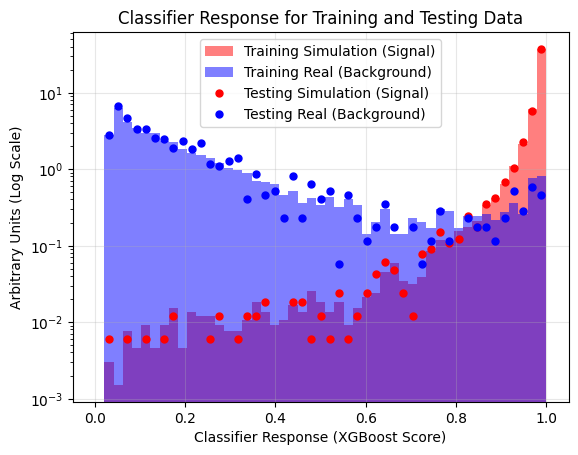

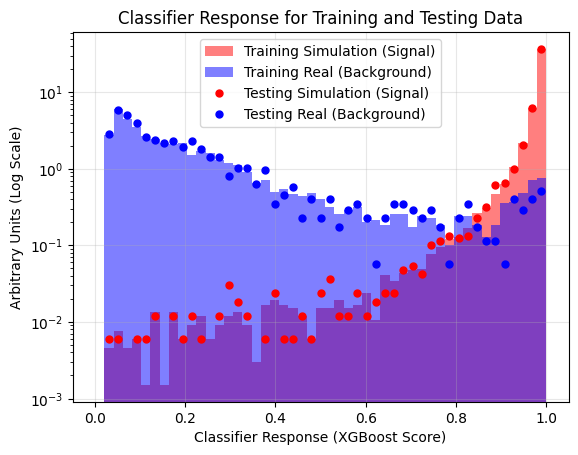

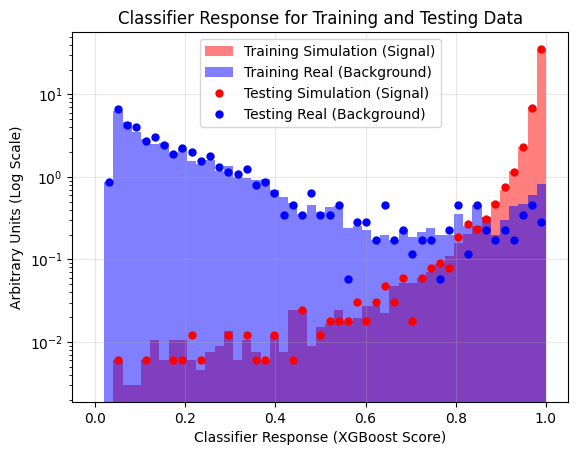

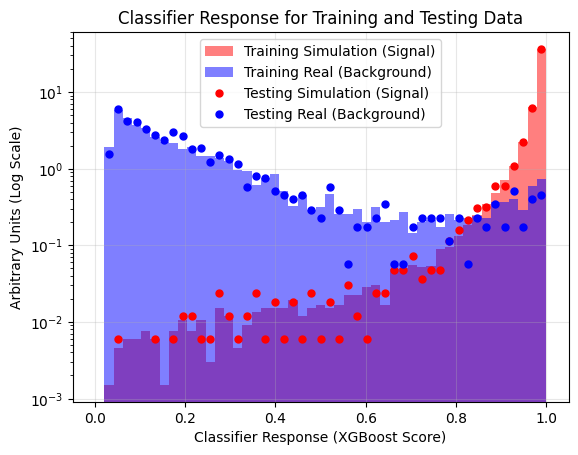

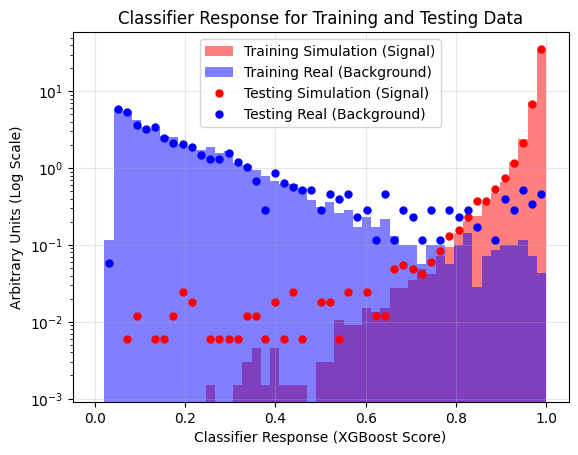

In [13]:
numb_of_classif = 5


for i in range (numb_of_classif):

    # Combine signal and background predictions for each set
    train_sim_signal = classif_list[i].predict_proba(X_train[y_train == 1])[:, 1]
    train_real_background = classif_list[i].predict_proba(X_train[y_train == 0])[:, 1]
    test_sim_signal = classif_list[i].predict_proba(X_test[y_test == 1])[:, 1]
    test_real_background = classif_list[i].predict_proba(X_test[y_test == 0])[:, 1]

    # Define bins for histograms
    bins = np.linspace(0, 1, 50)
    bin_centers = 0.5 * (bins[1:] + bins[:-1])

    # Histograms for training data
    train_sim_hist, _ = np.histogram(train_sim_signal, bins=bins, density=True)
    train_real_hist, _ = np.histogram(train_real_background, bins=bins, density=True)

    # Histograms for test data (used for alignment)
    test_sim_hist, _ = np.histogram(test_sim_signal, bins=bins, density=True)
    test_real_hist, _ = np.histogram(test_real_background, bins=bins, density=True)

    # Plot histograms for training data
    plt.hist(train_sim_signal, bins=bins, alpha=0.5, label="Training Simulation (Signal)", color="red", density=True, histtype="stepfilled")
    plt.hist(train_real_background, bins=bins, alpha=0.5, label="Training Real (Background)", color="blue", density=True, histtype="stepfilled")

    # Plot test data as dots
    plt.plot(bin_centers, test_sim_hist, 'o', label="Testing Simulation (Signal)", color="red", markersize=5)
    plt.plot(bin_centers, test_real_hist, 'o', label="Testing Real (Background)", color="blue", markersize=5)

    # Labels, legend, and title
    plt.xlabel("Classifier Response (XGBoost Score)")
    plt.ylabel("Arbitrary Units (Log Scale)")
    plt.title("Classifier Response for Training and Testing Data")
    plt.legend()
    plt.yscale("log")  # Logarithmic scale for better visualization
    plt.grid(alpha=0.3)

    plt.show()

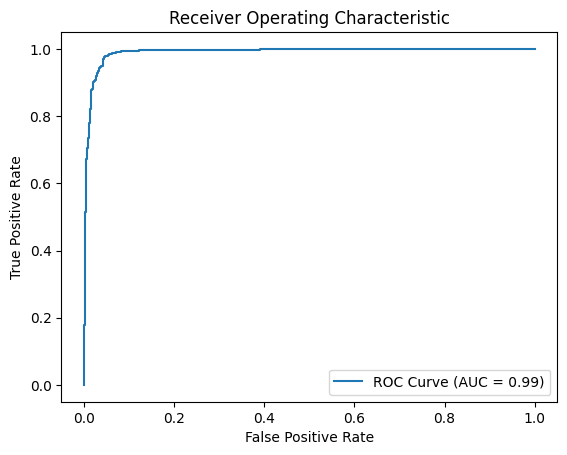

In [14]:
y_prob = model_es.predict_proba(X_test)[:, 1]  # Probabilities for the positive class
fpr, tpr, _ = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()


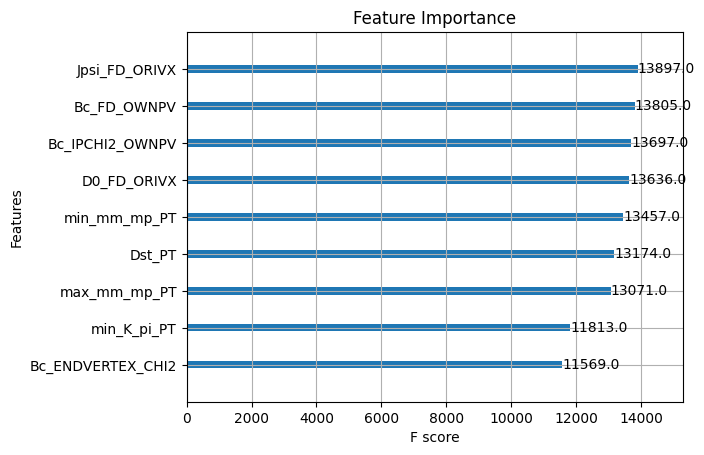

In [15]:

# Plot feature importance
plot_importance(model_es, importance_type='weight')
plt.title("Feature Importance")
plt.show()
